예제 목적

1. model.fit 리턴값 확인

- model.fit 은 내부적으로 epoch 으로 지정된 횟수만큼 반복하는것으로 판단됨. 그래서 epoch 당 무조건 손실 함수 값이 출력됨. 그러나 if step % 50 ==0:  과 같이 
 지정된 횟수에서만 손실함수 값을 출력하고 싶을때가 있음. 이럴경우, model.fit
 리턴값인 hist 를 이용하여 프로그래밍 할 수 있음.

- hist.history 객체는 dict 객체이고, metrics 를 별도로 지정하지 않으면 
key 값은 'loss', value 값은 epoch 할때마다 게산된 손실함수 값이 리스트 변수에 
저장도어 있음.

- 예를들어, hist = model.fit(.., epochs=3,..) 라고 할 경우,
 hist.history['loss'] = [ 0.3, 0.4, 0.5 ] 와 같이 리턴됨.

  - 그러므로 hist = model.fit(.., verbose=0)  if step % 50 ==0: print(hist.history['loss'][-1]) 하면 지정된 회수에서만 손실함수 값을 출력할수 있음 (verbose=0 옵션은 silent 이므로 화면에 출력되지 않음)


2. 손실함수 그릴때 필요한 계산 값 리스트로 얻기

- for step in range(2):  hist = model.fit(..,epochs=2) 이라고 할 경우, 
hist.history['loss'] = [ [0.1, 0.2], [0.2, 0.4] ] 같이 2차원 배열임. 그런데 손실함수 그래프 그리기 위해서는 1차원 배열같은 연속적인 값이어야함.

- 그래서 1차원 배열로 만들기 위해서, 먼저 numpy.flatten() 함수로 1차원 벡터로 변환 후, tolist() 메서드를 이용해서 리스트로 만들어주면 손실함수 값을 1차원 리스트에 연속적으로 저장할 수 있음


3. index_label_prediction_list 같은 정보를 만들기 위한 구현방식

- 먼저 predicted_val = model.predict(A) 리턴값은 넘파이 A 에 대한 모든 예측 값임. 

- 여기서 출력층 활성화 함수가 sigmoid 라면 predicted_val > 0.5 이면 True, 아니면 False 일것이므로 tf.cast, tf.equal 등으로 오답에 대한 리스트를 만들수 있을것으로 보임.

- 만약 one-hot encoding 이라면, tf.argmax 를 이용해서 비교할수 있을것으로 보임. 이 부분은 확인해볼 필요 있음

- list comprehension 이용하면 쉽게 구현가능함


In [1]:
import tensorflow as tf
import numpy as np
from datetime import datetime

print(tf.__version__)

2.2.0


In [2]:
from google.colab import drive   # colab 사용시 mount 하기 위한 용도. local 에서는 불필요

drive.mount('/content/gdrive/')  # colab 사용시 mount 하기 위한 용도. local 에서는 불필요

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import os

# TensorFlow 1.x working directory
working_dir = 'tensorflow_2.x_working_dir'


# Google Drive 에서 Colab Default Directory
colab_default_dir = '/content/gdrive/My Drive/Colab Notebooks/'


curr_dir = os.getcwd()  # save current dir

try:

    os.chdir(colab_default_dir)

    if not os.path.exists(working_dir):

        os.mkdir(working_dir)

    os.chdir(working_dir)  # change working dir

    print('current dir = ', os.getcwd())

except Exception as err:

    # 원래의 dir 로 복귀
    os.chdir(curr_dir)
    print(str(err))

current dir =  /content/gdrive/My Drive/Colab Notebooks/tensorflow_2.x_working_dir


In [4]:
try:

    loaded_data = np.loadtxt('./diabetes.csv', delimiter=',')

    x_data = loaded_data[ :, 0:-1]
    t_data = loaded_data[ :, [-1]]

    print("x_data.shape = ", x_data.shape)
    print("t_data.shape = ", t_data.shape)

except Exception as err:
    
    print(str(err))

x_data.shape =  (759, 8)
t_data.shape =  (759, 1)


In [0]:
model = tf.keras.models.Sequential()

In [0]:
# 입력층
input_layer = tf.keras.layers.Flatten(input_shape=(8,))
model.add(input_layer)

# 은닉층
hidden_layer = tf.keras.layers.Dense(10, activation='relu')
model.add(hidden_layer)

# 출력층
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')
model.add(output_layer)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [0]:
# optimizer
sgd = tf.keras.optimizers.SGD(lr=1e-2)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
hist_loss_list = []
hist_accuracy_list = []

epoch_num = 100

start_time = datetime.now()

for step in range(40):

    hist = model.fit(x_data, t_data, epochs=epoch_num, verbose=0)  # 50개의  값이 저장됨

    total_epoch_nums = (step+1) * epoch_num

    print('epochs = ', total_epoch_nums, ' , loss = ', hist.history['loss'][-1], ' , accuracy =  ', hist.history['accuracy'][-1])

    hist_loss_list.append(hist.history['loss'])  
    hist_accuracy_list.append(hist.history['accuracy'])

end_time = datetime.now()

print('\nElapsed time => ', end_time - start_time)

epochs =  100  , loss =  0.4823955297470093  , accuracy =   0.7720685005187988
epochs =  200  , loss =  0.4686092436313629  , accuracy =   0.7747035622596741
epochs =  300  , loss =  0.4655877947807312  , accuracy =   0.7747035622596741
epochs =  400  , loss =  0.46327972412109375  , accuracy =   0.7760210633277893
epochs =  500  , loss =  0.46112060546875  , accuracy =   0.7760210633277893
epochs =  600  , loss =  0.4588048756122589  , accuracy =   0.7720685005187988
epochs =  700  , loss =  0.4566279649734497  , accuracy =   0.7747035622596741
epochs =  800  , loss =  0.45420655608177185  , accuracy =   0.7760210633277893
epochs =  900  , loss =  0.45178163051605225  , accuracy =   0.7799736261367798
epochs =  1000  , loss =  0.44900205731391907  , accuracy =   0.7799736261367798
epochs =  1100  , loss =  0.44606345891952515  , accuracy =   0.7786561250686646
epochs =  1200  , loss =  0.44322314858436584  , accuracy =   0.7839261889457703
epochs =  1300  , loss =  0.4400964081287384 

In [10]:
loss_val_list = np.array(hist_loss_list).flatten().tolist()
accuracy_val_list = np.array(hist_accuracy_list).flatten().tolist()

print('loss_val_list length = ', len(loss_val_list))
print('accuracy_val_list length = ', len(accuracy_val_list))

loss_val_list length =  4000
accuracy_val_list length =  4000


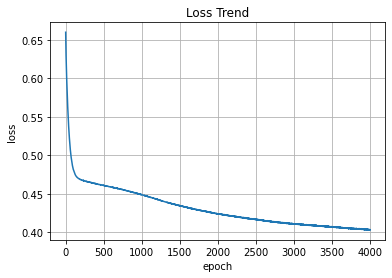

In [11]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.plot(loss_val_list)
plt.show()

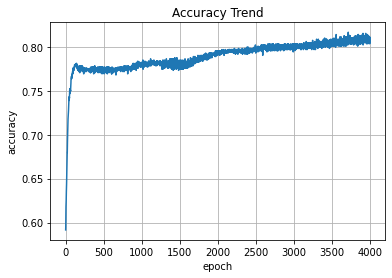

In [12]:
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.plot(accuracy_val_list)
plt.show()

In [13]:
# 손실, 정확도 평가
model.evaluate(x_data, t_data)

24/24 [==============================] - 0s 2ms/step - loss: 0.4026 - accuracy: 0.8103


[0.4026409983634949, 0.8102766871452332]

In [15]:
# model.predict()  리턴타입은 numpy

predicted_real_val = model.predict(x_data)

print(type(predicted_real_val), len(predicted_real_val))

print(predicted_real_val[:10])  # 임의로 10개 출력

<class 'numpy.ndarray'> 759
[[0.17001444]
 [0.98594683]
 [0.08787097]
 [0.99709904]
 [0.1734128 ]
 [0.82875425]
 [0.98608196]
 [0.62216765]
 [0.02165843]
 [0.53257394]]


In [16]:
# tf.cast()  리턴타입은 tensor

predicted_logical_val = tf.cast(predicted_real_val > 0.5, dtype=tf.float32)

print(type(predicted_logical_val), len(predicted_logical_val))

predicted_logical_val[:10]  # 임의로 값 출력. 타입은 텐서

<class 'tensorflow.python.framework.ops.EagerTensor'> 759


<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.]], dtype=float32)>

In [17]:
# tf.equal() , tf.cast() , tf.reduce_mean() 리턴타입은 tensor

accuracy_val = tf.reduce_mean( tf.cast(tf.equal(predicted_logical_val, t_data), dtype=tf.float32) )

print(type(accuracy_val), accuracy_val.numpy())  # 타입은 텐서, 넘파이로 변환 필요

<class 'tensorflow.python.framework.ops.EagerTensor'> 0.8102767


In [18]:
# 예측값과 정답을 비교하여 같으면 1, 다르면 0 을 가지는 텐서 comp_val

comp_val = tf.cast(tf.equal(predicted_logical_val, t_data), dtype=tf.float32)

print(comp_val[:10].numpy())

print(comp_val[:10].numpy()[0])  # t_data 는 슬라이싱으로 읽어들였기 때문에 1.0 이 아닌 [1.0] 임

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]]
[1.]


In [0]:
# 일반적인 for 문으로 index_label_prediction_list 만드는 방법

index_label_prediction_list = []
temp_list = []

for index in range(len(comp_val)):

    if comp_val[index].numpy()  == 0:    # false prediction

        temp_list.append(index)
        temp_list.append(float(t_data[index]))  # float() 해주지 않으면 넘파이 타입이 들어감. 순수 실수 값이 들어가도록 형변환 시킴
        temp_list.append(float(predicted_logical_val[index].numpy()))  # 텐서이므로 numpy() 변환 후 float()

        index_label_prediction_list.append(temp_list)

        temp_list = []

In [24]:
print( (len(comp_val)-len(index_label_prediction_list)) / len(comp_val) )  # 정확도 계산

print(1- ( len(index_label_prediction_list) / len(comp_val) ) )  # 정확도 계산

print(index_label_prediction_list[:5])

0.8102766798418972
0.8102766798418972
[[6, 0.0, 1.0], [9, 0.0, 1.0], [14, 0.0, 1.0], [16, 0.0, 1.0], [18, 0.0, 1.0]]


In [28]:
# list comprehension 으로 index_label_prediction_list_1 만드는 방법
# 즉 result == 0 이라는 것은 오답이라는 의미임

index_label_prediction_list_1 = [ [index, float(t_data[index]), float(predicted_logical_val[index].numpy()) ]  for index, result in enumerate(comp_val) if result == 0 ]

print( (len(comp_val)-len(index_label_prediction_list_1)) / len(comp_val) )  # 정확도 계산

print(1- ( len(index_label_prediction_list_1) / len(comp_val) ) )  # 정확도 계산

print(index_label_prediction_list_1[:5])

0.8102766798418972
0.8102766798418972
[[6, 0.0, 1.0], [9, 0.0, 1.0], [14, 0.0, 1.0], [16, 0.0, 1.0], [18, 0.0, 1.0]]
